# EEG Preprocessing

## Import packages

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import mne_bids

## Load dataset

In [ ]:
import os
import mne
import numpy as np
from collections import Counter

# file path
edf_folder = '/home/vhyun/Brainhack/project/MDD Patients and Healthy Controls EEG Data'
edf_files = [f for f in os.listdir(edf_folder) if f.endswith('EC.edf')]

# file sorting
def sort_key(filename):
    file_type = 0 if 'H' in filename.upper() else 1
    # 提取数字部分
    num = int(''.join(filter(str.isdigit, filename)))
    return (file_type, num)
edf_files.sort(key=sort_key)

# Group classification
mdd_files = [f for f in edf_files if 'MDD' in f.upper()]  # MDD: depression group
h_files = [f for f in edf_files if 'H' in f.upper()]      # H: healthy controls

print(f"Found {len(mdd_files)} MDD files and {len(h_files)} H files.")  # 30 MDD files, 28 H files
print(f"MDD files: {mdd_files}") 
print(f"H files: {h_files}")

# Save raw data and channel data
raw_list = []
channel_info = []  # channels name and band channel info of each files
all_channels = set() 

for edf_file in edf_files:
    edf_path = os.path.join(edf_folder, edf_file)
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    raw_list.append(raw)

    ch_names = raw.ch_names
    bads = raw.info['bads']
    channel_info.append({'file': edf_file, 'channels': ch_names, 'bads': bads})
    all_channels.update(ch_names)

print(f"Successfully loaded {len(raw_list)} EC.edf files!")

# calculate number of channels
channel_counts = Counter()
for info in channel_info:
    channel_counts.update(info['channels'])
    
# find mutual channels present in all files (some have 20, others 22 good channels)
common_channels = [ch for ch, count in channel_counts.items() if count == len(edf_files)]
print(f"Common channels across all files: {common_channels} (Count: {len(common_channels)})")

# calculate number of good or bad channels across files
for info in channel_info:
    good_channels = [ch for ch in info['channels'] if ch not in info['bads']]
    print(f"File: {info['file']}, Good Channels: {len(good_channels)}, Bad Channels: {len(info['bads'])}, Total: {len(info['channels'])}")

# visualize the bad channels
bad_channel_freq = Counter()
for info in channel_info:
    bad_channel_freq.update(info['bads'])
print("Bad channel frequency:", dict(bad_channel_freq))

## Visualize the raw data

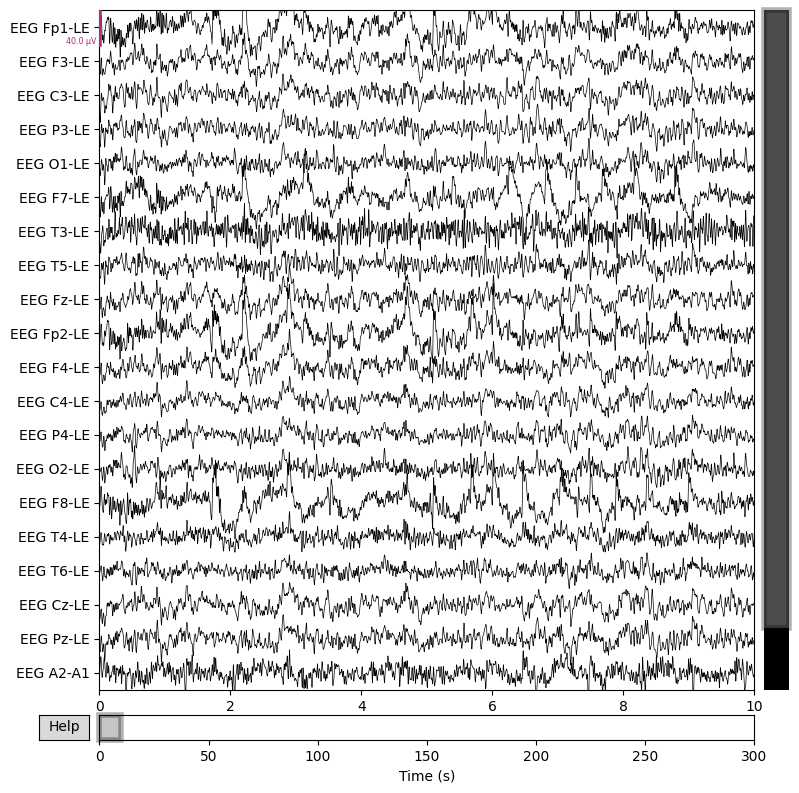

In [97]:
raw_list[0].plot();

## Raw data info

In [ ]:
#Common channels across all files: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1'] (Count: 20)

In [107]:
raw_list[0].info

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-LE, EEG F3-LE, EEG C3-LE, EEG P3-LE, EEG O1-LE, EEG ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 80.0 Hz
 meas_date: 2011-08-16 17:48:54 UTC
 nchan: 22
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>

In [104]:
raw_list[0].info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [68]:
# for key in raw_list[0].info.keys():
#     print(f"{key}: {raw_list[0].info[key]}")

In [64]:
# raw_list[0].info['custom_ref_applied']

0 (FIFFV_MNE_CUSTOM_REF_OFF)

## Select a subset of the channels (exclude EEG A2-A1 channel)

In [108]:
common_channels_with_ref = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE',
                           'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE',
                           'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE',
                           'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']
raw.pick_channels(common_channels_with_ref) 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | MDD S34 EC.edf, 19 x 76288 (298.0 s), ~11.1 MB, data loaded>

In [109]:
# channels rename
common_channels = [ch.replace('-LE', '').replace('EEG ', '') for ch in common_channels_with_ref]
raw.rename_channels({ch: ch.replace('-LE', '').replace('EEG ', '') for ch in common_channels_with_ref}) 

<RawEDF | MDD S34 EC.edf, 19 x 76288 (298.0 s), ~11.1 MB, data loaded>

## Visualize the sensor locations

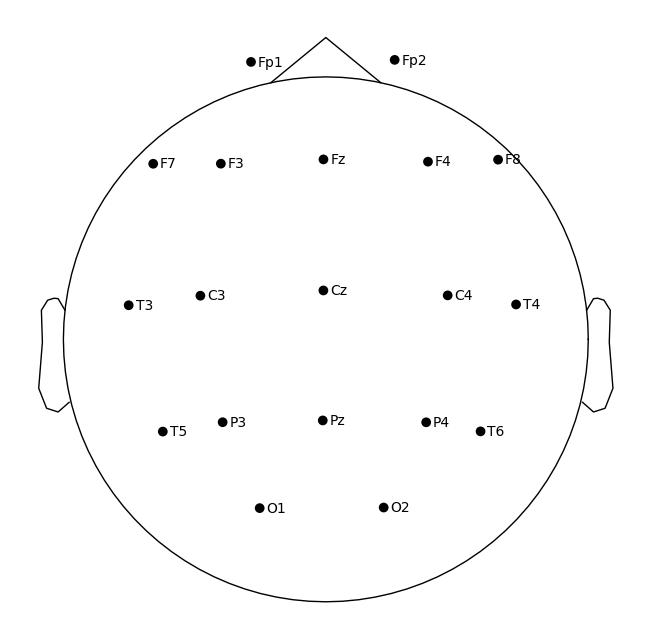

In [110]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False) 

raw.plot_sensors(kind='topomap', show_names=True)
plt.show() 

In [113]:
# batch processing
raw_list = [mne.io.read_raw_edf(os.path.join(edf_folder, f), preload=True)
            .pick_channels(common_channels_with_ref)
            .rename_channels({ch: ch.replace('-LE', '').replace('EEG ', '') for ch in common_channels_with_ref})
            .set_montage(montage, verbose=False) for f in edf_files]
print(f"Successfully loaded and processed {len(raw_list)} files with 19 channels each.")

Extracting EDF parameters from /home/vhyun/Brainhack/project/MDD Patients and Healthy Controls EEG Data/H S1 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/vhyun/Brainhack/project/MDD Patients and Healthy Controls EEG Data/H S2 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/vhyun/Brainhack/project/MDD Patients and Healthy Controls EEG Data/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
NOTE: pick_channels() is a legacy function. New code should use in

## Filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/home/vhyun/miniconda3/envs/brainhack/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


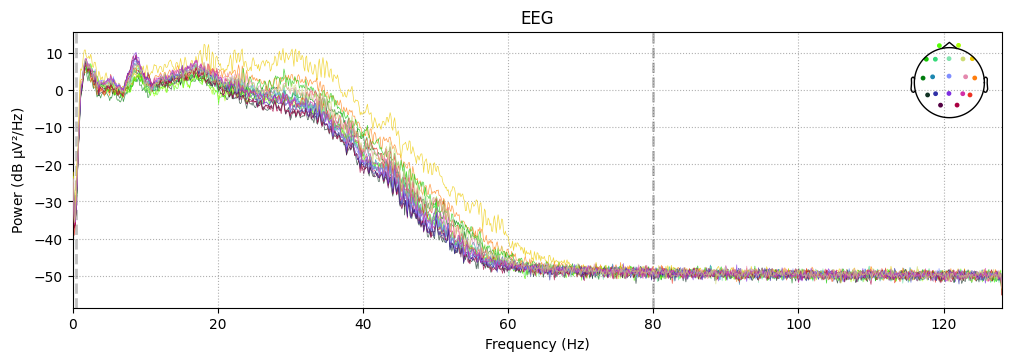

In [114]:
raw.plot_psd(picks=['eeg'])

### Figure from BHS module

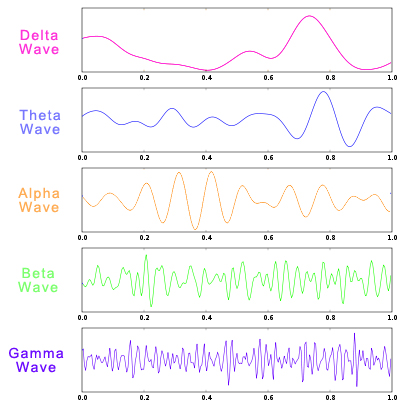

In [115]:
# batch process
raw_list_rf = [raw.copy()
               .set_eeg_reference(ref_channels='average', verbose=False)  # re-reference
               .filter(l_freq=1, h_freq=40, verbose=False)              # banpass filter 1-40 Hz
               #.notch_filter(freqs=50, verbose=False)                  # notch filter: 50 Hz
               for raw in ]
print(f"Successfully loaded and processed {len(raw_list_rf)} files with filtering applied.")

Successfully loaded and processed 58 files with filtering applied.


### Visualise psd

Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


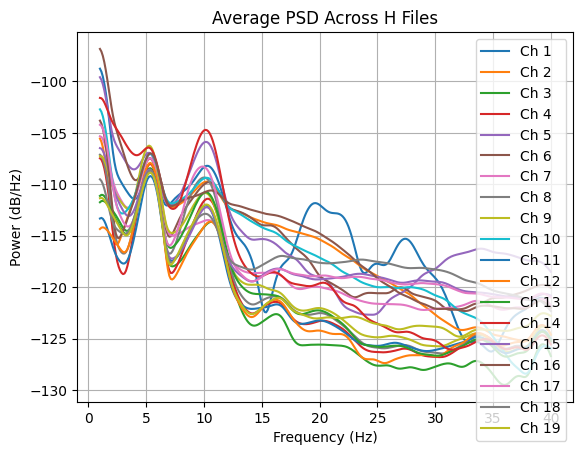

Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective wind

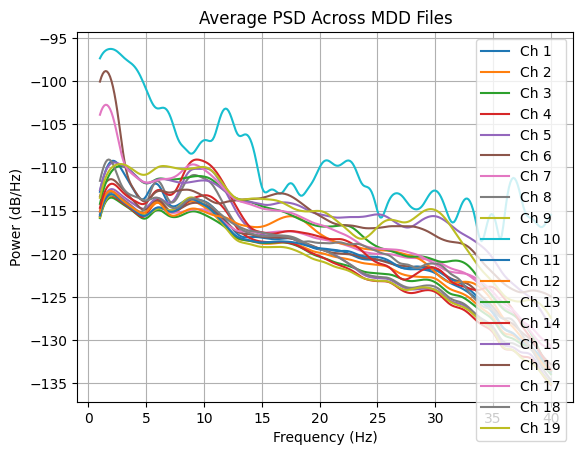

Plotted PSD for 28 H files and 30 MDD files.


In [125]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# select raw data of h and mdd
h_indices = [i for i, f in enumerate(edf_files) if f in h_files]
mdd_indices = [i for i, f in enumerate(edf_files) if f in mdd_files]

raw_list_h = [raw_list_rf[i] for i in h_indices]
raw_list_mdd = [raw_list_rf[i] for i in mdd_indices]

# calculate and plotting average of psd
def plot_group_psd(raw_list, group_name):
    psds = []
    for raw in raw_list:
        psd = raw.compute_psd(picks='eeg', fmin=1, fmax=40, n_per_seg=256)  # bandpass 1-40 Hz
        psd_data, freqs = psd.get_data(return_freqs=True)
        psds.append(psd_data)
    mean_psd = np.mean(psds, axis=0)
    plt.figure()

    for i in range(mean_psd.shape[0]):
        plt.plot(freqs, 10 * np.log10(mean_psd[i, :]), label=f'Ch {i+1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB/Hz)')
    plt.title(f'Average PSD Across {group_name} Files')
    plt.legend()
    plt.grid()
    plt.show()

# plotting average of psd across H and MDD
plot_group_psd(raw_list_h, 'H')
plot_group_psd(raw_list_mdd, 'MDD')

print(f"Plotted PSD for {len(raw_list_h)} H files and {len(raw_list_mdd)} MDD files.")

## Creating epochs

In [136]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt

# epoch parameter
tmin, tmax = 0, 4  # 4second epoch
event_id = 1      # no event

# save X and Y data used in deep learning
all_epochs_data = [] # save preprocess data of each epoch
all_epoch_labels = [] # save label data of each epoch

# H
print("\nProcessing H group epochs...")
for raw_h in raw_list_h:
    events = mne.make_fixed_length_events(raw_h, id=event_id, duration=tmax, overlap=0)
    epochs_h = mne.Epochs(raw_h, events, event_id, tmin, tmax, baseline=None, preload=True, verbose=False)
    for epoch_data in epochs_h.get_data():
        all_epochs_data.append(epoch_data)
        all_epoch_labels.append(0)    # label as 0

# MDD
print("\nProcessing MDD group epochs...")
for raw_mdd in raw_list_mdd:
    events = mne.make_fixed_length_events(raw_mdd, id=event_id, duration=tmax, overlap=0)
    epochs_mdd = mne.Epochs(raw_mdd, events, event_id, tmin, tmax, baseline=None, preload=True, verbose=False)
    for epoch_data in epochs_mdd.get_data():
        all_epochs_data.append(epoch_data)
        all_epoch_labels.append(1)    # label as 1

# Save data for deep learning training
X_epochs_data = np.array(all_epochs_data)
y_epoch_labels = np.array(all_epoch_labels)

print(f"\nTotal epochs collected: {X_epochs_data.shape[0]}")
print(f"Shape of X_epochs_data (data for ml/dl): {X_epochs_data.shape}")    # (4308, 19, 1025)
print(f"Shape of y_epoch_labels (labels for ml/dl): {y_epoch_labels.shape}")    # (4308,)


Processing H group epochs...

Processing MDD group epochs...

Total epochs collected: 4308
Shape of X_epochs_data (data for ml/dl): (4308, 19, 1025)
Shape of y_epoch_labels (labels for ml/dl): (4308,)


In [137]:
output_dir = '/home/vhyun/Brainhack/project'
X_filename = 'X_epochs_data.npy'
y_filename = 'y_epoch_labels.npy'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

np.save(os.path.join(output_dir, X_filename), X_epochs_data)
np.save(os.path.join(output_dir, y_filename), y_epoch_labels)
print(f"Saved X_epochs_data to {os.path.join(output_dir, X_filename)}")
print(f"Saved y_epoch_labels to {os.path.join(output_dir, y_filename)}")

Saved X_epochs_data to /home/vhyun/Brainhack/project/X_epochs_data.npy
Saved y_epoch_labels to /home/vhyun/Brainhack/project/y_epoch_labels.npy


# Bandpower Feature

In [140]:
import numpy as np
from mne.time_frequency import psd_array_welch

bands = {
    'delta': [1, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 40]
}

X_features = []

for epoch in X_epochs_data:
    psds, freqs = psd_array_welch(epoch, sfreq=256, fmin=1, fmax=40, n_fft=epoch.shape[1], verbose=False)

    band_features = []
    for band, (fmin, fmax) in bands.items():
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        if np.any(idx):
            band_power = psds[:, idx].mean(axis=1)  
        else:
            band_power = np.zeros(epoch.shape[0])
        band_features.extend(band_power)

    X_features.append(band_features)

X_features = np.array(X_features)
y_labels = np.array(y_epoch_labels)

print("X_features shape:", X_features.shape)  # (4308, 95)
print("y_labels shape:", y_labels.shape)      # (4308,)

X_features shape: (4308, 95)
y_labels shape: (4308,)


In [141]:
output_dir = '/home/vhyun/Brainhack/project'
X_filename = 'X_features.npy'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

np.save(os.path.join(output_dir, X_filename), X_features)
print(f"Saved X_features to {os.path.join(output_dir, X_filename)}")

Saved X_features to /home/vhyun/Brainhack/project/X_features.npy


In [1]:
import os
data_dir = os.path.abspath('/home/vhyun/Brainhack/project')

import numpy as np
# 载入你的数据文件
X_epochs = np.load("X_epochs_data.npy")         # shape 应该是 (n_epochs, n_channels, n_times)
X_features = np.load("X_features.npy")          # shape 应该是 (n_epochs, n_bandpower_features)
y_labels = np.load("y_epoch_labels.npy")        # shape 应该是 (n_epochs,)

# 检查 shape 是否对上
print(X_epochs.shape)
print(X_features.shape)
print(y_labels.shape)

(4308, 19, 1025)
(4308, 95)
(4308,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_features,        # 特征输入
    y_labels,          # 对应标签（H vs MDD）
    test_size=0.4,     # 60/40 分割
    shuffle=True,
    stratify=y_labels, # 保持 H/MDD 比例一致
    random_state=123
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))

Train size: 2584
Validation size: 1724


In [15]:
# from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
        ('scaler', StandardScaler()),
        # ('feature_selection',SelectPercentile(f_classif,percentile=20)),
        ('prediction', SVC(kernel='linear', C=100, gamma=1))
                 ])

y_pred = [] # a container to catch the predictions from each fold
y_index = [] # just in case, the index for each prediction

# First we create 10 splits of the data
skf = KFold(n_splits=10, shuffle=True, random_state=123)

# For each split, assemble the train and test samples 
for tr_ind, te_ind in skf.split(X_train):
    X_tr = X_train[tr_ind]
    y_tr = y_train[tr_ind]
    X_te = X_train[te_ind]
    y_index += list(te_ind) # store the index of samples to predict
    
    # and run our pipeline 
    model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
    predictions = model.predict(X_te).tolist() # get the predictions for this fold
    y_pred += predictions # add them to the list of predictions

In [16]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_train[y_index], y_pred)

print('ACC:',acc)

ACC: 0.9585913312693498


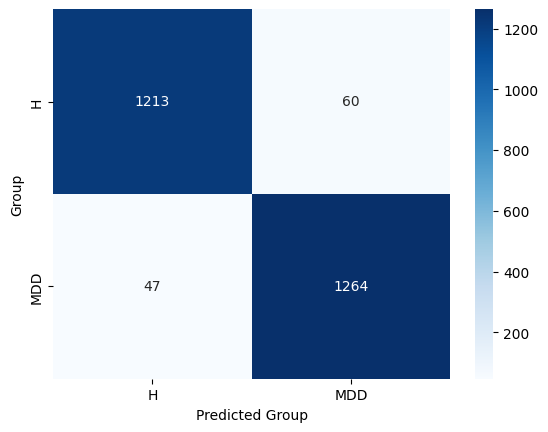

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train[y_index], y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H', 'MDD'],
            yticklabels=['H', 'MDD'])
plt.xlabel('Predicted Group')
plt.ylabel('Group')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'prediction__C': 10. ** np.arange(-3, 8),
    'prediction__gamma': 10. ** np.arange(-3, 8)
}

grid = GridSearchCV(model, param_grid=param_grid, cv=10)

grid.fit(X_train, y_train)

print(grid.best_params_)

In [18]:
# from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection',SelectPercentile(f_classif,percentile=20)),
        ('prediction', SVC(kernel='linear', C=100, gamma=1))
                 ])

y_pred = [] # a container to catch the predictions from each fold
y_index = [] # just in case, the index for each prediction

# First we create 10 splits of the data
skf = KFold(n_splits=10, shuffle=True, random_state=123)

# For each split, assemble the train and test samples 
for tr_ind, te_ind in skf.split(X_train):
    X_tr = X_train[tr_ind]
    y_tr = y_train[tr_ind]
    X_te = X_train[te_ind]
    y_index += list(te_ind) # store the index of samples to predict
    
    # and run our pipeline 
    model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
    predictions = model.predict(X_te).tolist() # get the predictions for this fold
    y_pred += predictions # add them to the list of predictions

In [19]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_train[y_index], y_pred)

print('ACC:',acc)

ACC: 0.8777089783281734


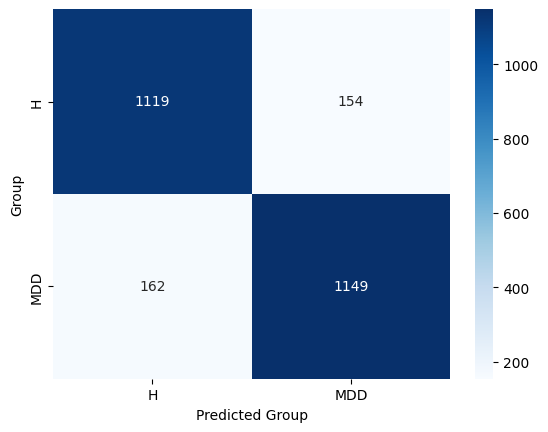

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train[y_index], y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H', 'MDD'],
            yticklabels=['H', 'MDD'])
plt.xlabel('Predicted Group')
plt.ylabel('Group')
plt.show()

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

model = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif, k=50)),
        ('prediction', SVC(kernel='linear', C=100, gamma=1))
                 ])

y_pred = [] # a container to catch the predictions from each fold
y_index = [] # just in case, the index for each prediction

# First we create 10 splits of the data
skf = KFold(n_splits=10, shuffle=True, random_state=123)

# For each split, assemble the train and test samples 
for tr_ind, te_ind in skf.split(X_train):
    X_tr = X_train[tr_ind]
    y_tr = y_train[tr_ind]
    X_te = X_train[te_ind]
    y_index += list(te_ind) # store the index of samples to predict
    
    # and run our pipeline 
    model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
    predictions = model.predict(X_te).tolist() # get the predictions for this fold
    y_pred += predictions # add them to the list of predictions

In [31]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_train[y_index], y_pred)

print('ACC:',acc)

ACC: 0.9202786377708978


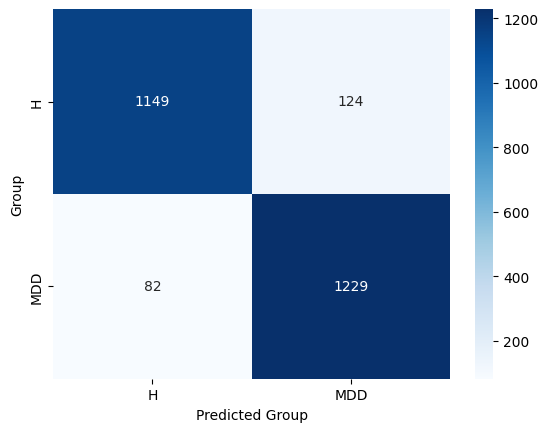

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train[y_index], y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H', 'MDD'],
            yticklabels=['H', 'MDD'])
plt.xlabel('Predicted Group')
plt.ylabel('Group')
plt.show()

In [33]:
# from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

model = Pipeline([
        ('scaler', StandardScaler()),
        #('feature_selection',SelectPercentile(f_classif,percentile=20)),
        ('dim_reduction', PCA(n_components=10, random_state=123)),
        ('prediction', SVC(kernel='linear', C=100, gamma=1))
                 ])

y_pred = [] # a container to catch the predictions from each fold
y_index = [] # just in case, the index for each prediction

# First we create 10 splits of the data
skf = KFold(n_splits=10, shuffle=True, random_state=123)

# For each split, assemble the train and test samples 
for tr_ind, te_ind in skf.split(X_train):
    X_tr = X_train[tr_ind]
    y_tr = y_train[tr_ind]
    X_te = X_train[te_ind]
    y_index += list(te_ind) # store the index of samples to predict
    
    # and run our pipeline 
    model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
    predictions = model.predict(X_te).tolist() # get the predictions for this fold
    y_pred += predictions # add them to the list of predictions


In [34]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_train[y_index], y_pred)

print('ACC:',acc)

ACC: 0.8459752321981424


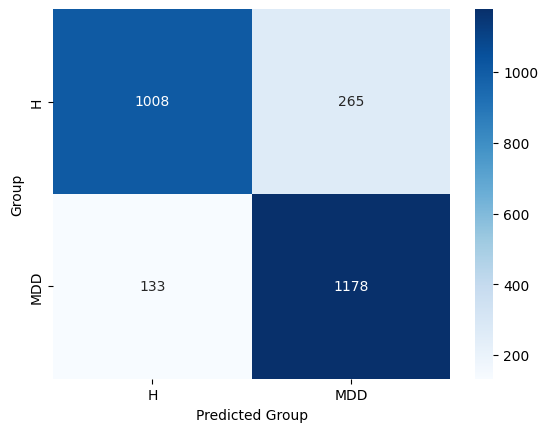

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train[y_index], y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H', 'MDD'],
            yticklabels=['H', 'MDD'])
plt.xlabel('Predicted Group')
plt.ylabel('Group')
plt.show()